In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기

In [95]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [5]:
train.info()  ## 결측치는 없다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
test.info()  ## 결측치는 없다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

### eda

In [7]:
train.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.020899,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.010520,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


In [8]:
## train의 zipcode와 test의 zipcode가 동일하다, target encoding 고려
set(train["zipcode"].unique())==set(test["zipcode"].unique())
# print(train["zipcode"].sort_values().unique())
# print(test["zipcode"].sort_values().unique())

True

<AxesSubplot:xlabel='zipcode', ylabel='price'>

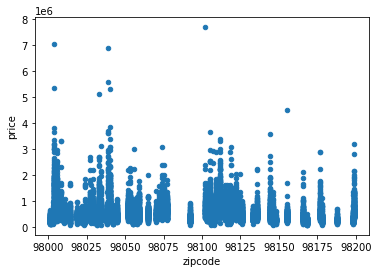

In [9]:
## zipcode에 따른 price
train.plot(x="zipcode", y="price", kind="scatter")

<AxesSubplot:xlabel='long', ylabel='lat'>

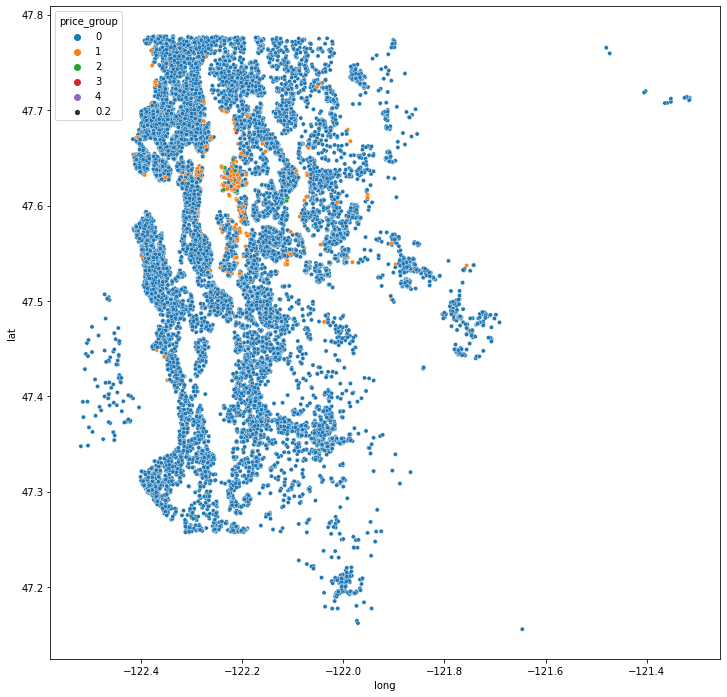

In [10]:
## 위도 경도에 따른 price
train["price_group"] = pd.cut(train["price"], bins=5, labels=range(5))
plt.figure(figsize=(12,12))
sns.scatterplot(data=train, x="long", y="lat", hue="price_group",size=0.2)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [13]:
# fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# # id 변수는 제외하고 분포를 확인합니다.
# count = 0
# columns = train.columns
# for row in range(11):
#     for col in range(2):
#         sns.kdeplot(train[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count+=1
#         if count == 19 :
#             break

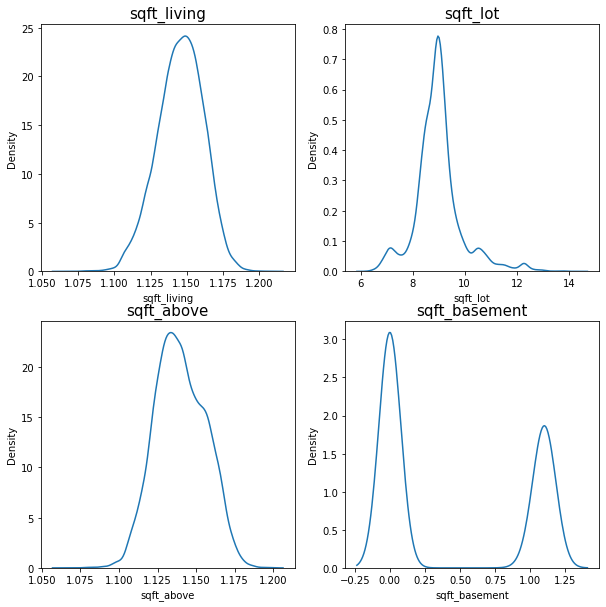

In [98]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

count = 0
for row in range(2):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [15]:
train["yr_built"].describe()

count    15035.000000
mean      1971.100432
std         29.407612
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

<AxesSubplot:xlabel='yr_built', ylabel='price'>

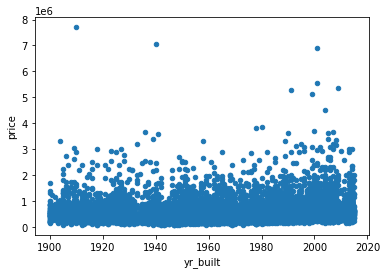

In [16]:
train.plot(x="yr_built", y="price", kind="scatter")

In [17]:
## yr_renovated != 0 인 수
train["yr_renovated"].describe()

count    15035.000000
mean        83.798936
std        400.398498
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

<AxesSubplot:xlabel='yr_renovated', ylabel='price'>

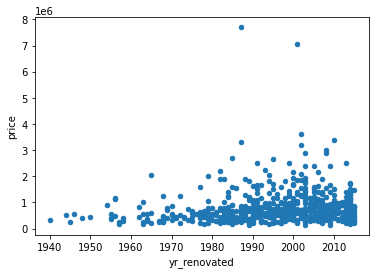

In [18]:
train[train["yr_renovated"] != 0].plot(x="yr_renovated", y="price", kind="scatter") ## 0인 아닌 값들

In [19]:
train["renovated"] = train["yr_renovated"] != 0
train["renovated"] = train["renovated"].astype(int)

<AxesSubplot:xlabel='renovated', ylabel='price'>

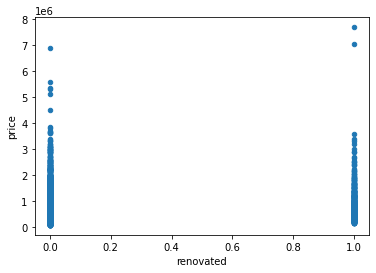

In [20]:
train.plot(x="renovated", y="price", kind="scatter")

<AxesSubplot:xlabel='zipcode_group', ylabel='price'>

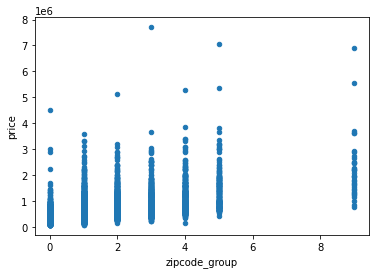

In [21]:
## zipcode를 target encoding
zip_by_price = train.groupby("zipcode")[["price"]].mean()
zip_by_price = zip_by_price.reset_index().rename(columns={"price":"price_mean"})
zip_by_price["zipcode_group"] = pd.cut(zip_by_price["price_mean"], bins=10, labels=range(10))
train = pd.merge(train, zip_by_price[["zipcode", "zipcode_group"]], how="left", on="zipcode")

train.plot(x="zipcode_group", y="price", kind="scatter")

### 데이터 전처리

In [197]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [198]:
def zipcode_group_processor(train):
    zip_by_price = train.groupby("zipcode")[["price"]].mean()
    zip_by_price = zip_by_price.reset_index().rename(columns={"price":"price_mean"})
    zip_by_price["zipcode_group"] = pd.cut(zip_by_price["price_mean"], bins=25, labels=range(25))
    
    return zip_by_price

def feature_engineering(
    data, 
    zip_by_price, 
    skew_columns = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']
):    
    ## zipcode
    data = pd.merge(data, zip_by_price[["zipcode", "zipcode_group"]], how="left", on="zipcode")
    data["zipcode_group"] = data["zipcode_group"].astype(int)
    
    ### kaggle code 참고!
    ## year 관련
    data['how_old'] = data['date'].apply(lambda x: x[:4]).astype(int) - data[['yr_built', 'yr_renovated']].max(axis=1) # 얼마나 됐는지 연식
    data['yr_built'] = data['yr_built'] - 1900 # 건축년도 1900년도로부터 얼마나 됐는지 
    data['yr_built'] = pd.cut(data['yr_built'], bins=10, labels=range(10)).astype(int)
#     ## sqft 관련
#     data['sqft_diff'] = data['sqft_living15'] - data['sqft_living']
#     data['sqft_living_lot_diff'] = data['sqft_lot'] - data['sqft_living']
    
    ## level 관련 
    data['sum_level'] = data['grade'] + data['view'] + data['condition']
#     data['multi_level'] = data['grade'] * (data['view']+1) * data['condition']
    
#     data['condition_2'] = data['condition'].apply(lambda x : 0 if x < 3 else x)
#     data['sum_level_2'] = data['view'] + data['condition_2'] + data['grade']
    
    ## drop
    data = data.drop(columns=["id", "date", "zipcode"])
    
    ## skew -> log transform
    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    
    return data

In [199]:
## feature engineering 
zip_by_price = zipcode_group_processor(train)

train = feature_engineering(train, zip_by_price)
test = feature_engineering(test, zip_by_price)

## X, y spilt
X = train.drop(columns=["price"])
y = train["price"]
y = np.log1p(y)

In [200]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'zipcode_group', 'how_old', 'sum_level'],
      dtype='object')

### 하이퍼파라미터 튜닝 & 모델링

In [25]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [26]:
xgb_params_grid = {
    "max_depth" : [3, 6, 9], 
    "learning_rate" : [0.01, 0.05, 0.1], 
    "num_iterations" : [50, 100], 
#     "num_leaves" : [10, 20, 30, 40, 50], 
    "random_state" : [0, 42, 2024]
}

lgb_params_grid = {
    "max_depth" : [3, 6, 9], 
    "learning_rate" : [0.01, 0.05, 0.1], 
    "n_estimaters" : [50, 100], 
    "num_leaves" : [10, 20, 30, 40, 50], 
    "random_state" : [0, 42, 2024]
}
xgb_model = XGBRegressor()
lgb_model = LGBMRegressor()

In [27]:
xgb_result = my_GridSearch(xgb_model, X, y, xgb_params_grid)
lgb_result = my_GridSearch(lgb_model, X, y, lgb_params_grid)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

[12:05:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.01, max_depth=3, num_iterations=50, random_state=0; total time=  22.2s
[12:05:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.01, max_depth=3, num_iterations=50, random_state=42; total time=  20.9s
[12:06:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some

[12:05:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.01, max_depth=3, num_iterations=50, random_state=0; total time=  23.9s
[12:05:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.01, max_depth=3, num_iterations=50, random_state=42; total time=  24.2s
[12:06:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some

[12:05:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.01, max_depth=3, num_iterations=50, random_state=0; total time=  21.3s
[12:05:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.01, max_depth=3, num_iterations=50, random_state=42; total time=  22.5s
[12:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some

[CV] END learning_rate=0.01, max_depth=9, num_iterations=100, random_state=2024; total time=  34.4s
[12:12:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.05, max_depth=3, num_iterations=50, random_state=0; total time=  22.1s
[12:13:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.05, max_depth=3, num_iterations=50, random_state=42; total time=  23.6s
[12:13:37] WARNING: ../src/learner.

[CV] END learning_rate=0.05, max_depth=3, num_iterations=50, random_state=42; total time=  18.7s
[12:13:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.05, max_depth=3, num_iterations=50, random_state=2024; total time=  26.6s
[12:13:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.05, max_depth=3, num_iterations=100, random_state=0; total time=  27.4s
[12:14:16] WARNING: ../src/learner.

[12:41:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[12:25:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.05, max_depth=9, num_iterations=100, random_state=2024; total time= 1.1min
[12:26:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in 

[12:26:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.1, max_depth=3, num_iterations=50, random_state=42; total time=  17.7s
[12:26:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.1, max_depth=3, num_iterations=50, random_state=2024; total time=  18.6s
[12:27:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to som

[12:26:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.1, max_depth=3, num_iterations=50, random_state=0; total time=  24.8s
[12:26:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END learning_rate=0.1, max_depth=3, num_iterations=50, random_state=42; total time=  19.8s
[12:26:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some p

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=30, random_state=0; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=30, random_state=0; total time=   0.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=30, random_state=42; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=30, random_state=2024; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=40, random_state=0; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=40, random_state=42; total time=   0.8s
[LightGBM] [Warning] Un

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=20, random_state=2024; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=30, random_state=0; total time=   1.2s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=30, random_state=2024; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=40, random_state=0; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=40, random_state=42; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=3, n_estimaters=50, num_leaves=40, random_state=2024; total time=   1.2s
[LightGBM] [Warnin

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=30, random_state=2024; total time=   1.6s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=40, random_state=0; total time=   1.6s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=40, random_state=0; total time=   2.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=40, random_state=42; total time=   1.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=40, random_state=2024; total time=   1.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=50, random_state=0; total time=   2.1s
[LightGBM] [War

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=40, random_state=2024; total time=   2.5s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=50, random_state=0; total time=   2.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=50, random_state=42; total time=   2.2s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=50, random_state=2024; total time=   1.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=9, n_estimaters=50, num_leaves=10, random_state=0; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=9, n_estimaters=50, num_leaves=10, random_state=42; total time=   1.0s
[LightGBM] [Warn

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=40, random_state=2024; total time=   1.6s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=50, random_state=0; total time=   1.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=50, random_state=42; total time=   2.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=6, n_estimaters=100, num_leaves=50, random_state=2024; total time=   2.4s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=9, n_estimaters=50, num_leaves=10, random_state=0; total time=   1.5s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.01, max_depth=9, n_estimaters=50, num_leaves=10, random_state=42; total time=   1.5s
[LightGBM] [Warn


[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=50, num_leaves=50, random_state=42; total time=   0.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=50, num_leaves=50, random_state=2024; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=10, random_state=0; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=10, random_state=42; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=10, random_state=2024; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=20, random_state=0; total time=   1.1s
[LightGBM] [War

[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=20, random_state=0; total time=   2.1s[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=10, random_state=42; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=20, random_state=0; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=20, random_state=42; total time=   0.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=20, random_state=2024; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=30, random_state=0; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_r

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=20, random_state=0; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=20, random_state=42; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=30, random_state=0; total time=   0.7s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=30, random_state=0; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=30, random_state=42; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=3, n_estimaters=100, num_leaves=30, random_state=2024; total time=   0.8s
[LightGBM] [Warni

[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=10, random_state=0; total time=   0.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=10, random_state=42; total time=   1.2s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=10, random_state=2024; total time=   1.4s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=20, random_state=0; total time=   1.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=20, random_state=42; total time=   2.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=20, random_state=2024; total time=   1.7s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_ra

[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=30, random_state=0; total time=   2.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=30, random_state=42; total time=   1.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=30, random_state=2024; total time=   1.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=40, random_state=0; total time=   2.6s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=40, random_state=42; total time=   2.5s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.05, max_depth=9, n_estimaters=50, num_leaves=40, random_state=2024; total time=   2.5s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_ra

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=20, random_state=42; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=20, random_state=2024; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=30, random_state=0; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=30, random_state=2024; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=40, random_state=0; total time=   0.7s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=40, random_state=42; total time=   0.7s
[LightGBM] [Warning]

[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=40, random_state=2024; total time=   0.7s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=50, random_state=0; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=50, random_state=42; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=50, random_state=2024; total time=   0.7s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=6, n_estimaters=50, num_leaves=10, random_state=0; total time=   1.2s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=6, n_estimaters=50, num_leaves=10, random_state=42; total time=   1.1s
[LightGBM] [Warning] U

[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=40, random_state=2024; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=50, random_state=42; total time=   0.9s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=50, random_state=42; total time=   0.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=3, n_estimaters=100, num_leaves=50, random_state=2024; total time=   0.7s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=6, n_estimaters=50, num_leaves=10, random_state=0; total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=6, n_estimaters=50, num_leaves=10, random_state=42; total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rat

In [28]:
print(xgb_result.iloc[0,:])
print(lgb_result.iloc[0,:])

learning_rate        0.100000
max_depth            9.000000
num_iterations     100.000000
random_state      2024.000000
score               -0.027604
RMSLE                0.166146
Name: 53, dtype: float64
learning_rate     0.100000
max_depth         9.000000
n_estimaters     50.000000
num_leaves       40.000000
random_state     42.000000
score            -0.027584
RMSLE             0.166085
Name: 250, dtype: float64
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=100, num_leaves=10, random_state=2024; total time=   1.2s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=100, num_leaves=20, random_state=0; total time=   1.3s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=100, num_leaves=20, random_state=42; total time=   1.8s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=100, num_leaves=20, random_state=202

[CV] END learning_rate=0.1, max_depth=9, n_estimaters=50, num_leaves=50, random_state=0; total time=   2.6s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=50, num_leaves=50, random_state=42; total time=   2.4s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=50, num_leaves=50, random_state=2024; total time=   2.6s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=100, num_leaves=10, random_state=0; total time=   1.3s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=100, num_leaves=10, random_state=42; total time=   1.4s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=0.1, max_depth=9, n_estimaters=100, num_leaves=10, random_state=2024; total time=   1.3s
[LightGBM] [Warning] Unknown parameter: n_estimaters
[CV] END learning_rate=

In [223]:
rf_params = {
    "n_estimators" : 100, 
    "max_depth" : 5, 
    "random_state" : 42
}
xgb_params = {
    "learning_rate" : 0.05, ## learning rate 조젇 0.1 -> 0.05
    "max_depth" : 6,
    "n_estimators" : 500, ## 파라미터 이름 조정 num_iterations -> n_estimaters
    "random_state" : 2024
}
lgb_params = {
    "learning_rate" : 0.05, ## learning rate 조정 0.1 -> 0.05
    "max_depth" : 6,
    "num_iterations" : 500, ## 파라미터 이름 조정 n_estimaters -> num_iterations
    "num_leaves" : 40,
    "random_state" : 42, 
    "boosting_type" : "gbdt"
}

In [224]:
rf_model = RandomForestRegressor(**rf_params)
xgb_model = XGBRegressor(**xgb_params)
lgb_model = LGBMRegressor(**lgb_params)
 
models = [
    ('RandomForest', rf_model), 
    ('XGBoost', xgb_model),
    ('LightGBM', lgb_model)
]

In [225]:
reg = StackingRegressor(
    estimators=models,
#     final_estimator=RandomForestRegressor(n_estimators=100,
#                                           random_state=42)
)

In [226]:
reg.fit(X, y)
prediction = reg.predict(test)
prediction = np.expm1(prediction)

### Make Submission

In [227]:
def save_submission(prediction):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_stacking.csv'.format(data_dir)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [228]:
save_submission(prediction)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_stacking_remove_rf.csv saved!
